In [4]:
import sys
import os
import warnings
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import dataset as ds
import s3fs
s3 = s3fs.S3FileSystem()

In [14]:
import geopandas as gpd
from shapely import Polygon

## Load data/sample3

In [8]:
traj_cols = {'user_id':'uid',
             'latitude':'latitude',
             'longitude':'longitude',
             'time':'timestamp'}

path = '../data/sample3'
single_user = False
file_format = "csv"
partitioning= "hive"

In [9]:
dataset = ds.dataset(path, format="parquet", partitioning="hive")
df = dataset.to_table().to_pandas()
df 

,uid,timestamp,latitude,longitude,date
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01
0,wonderful_swirles,1704121560,38.321017,-36.667869,2024-01-01
0,youthful_galileo,1704098820,38.321625,-36.666612,2024-01-01
1,youthful_galileo,1704103140,38.321681,-36.666841,2024-01-01
...,...,...,...,...,...
1691,angry_spence,1705303380,38.320399,-36.667438,2024-01-15
1692,angry_spence,1705303740,38.320413,-36.667469,2024-01-15
1693,angry_spence,1705303980,38.320384,-36.667455,2024-01-15
1694,angry_spence,1705304340,38.320349,-36.667473,2024-01-15


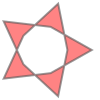

In [19]:
# Calculate bounds from the latitude and longitude of the points
min_lat = df['latitude'].min()
max_lat = df['latitude'].max()
min_lon = df['longitude'].min()
max_lon = df['longitude'].max()

# Define the center of the star and its size based on the bounds
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2
size = min(max_lat - min_lat, max_lon - min_lon) / 1.5  # Size of the star

# Define the points for a 5-point star
points = []
for i in range(5):
    # Outer points
    outer_angle = i * 144 * (np.pi / 180)  # 144 degrees in radians
    outer_x = center_lon + size * 0.5 * np.cos(outer_angle)
    outer_y = center_lat + size * 0.5 * np.sin(outer_angle)
    points.append((outer_x, outer_y))
    
    # Inner points
    inner_angle = (i * 144 + 72) * (np.pi / 180)  # 72 degrees for inner points
    inner_x = center_lon + size * 0.25 * np.cos(inner_angle)
    inner_y = center_lat + size * 0.25 * np.sin(inner_angle)
    points.append((inner_x, inner_y))

# Create a Shapely polygon for the star
star_polygon = Polygon(points)

star_polygon  # Display the star polygon object

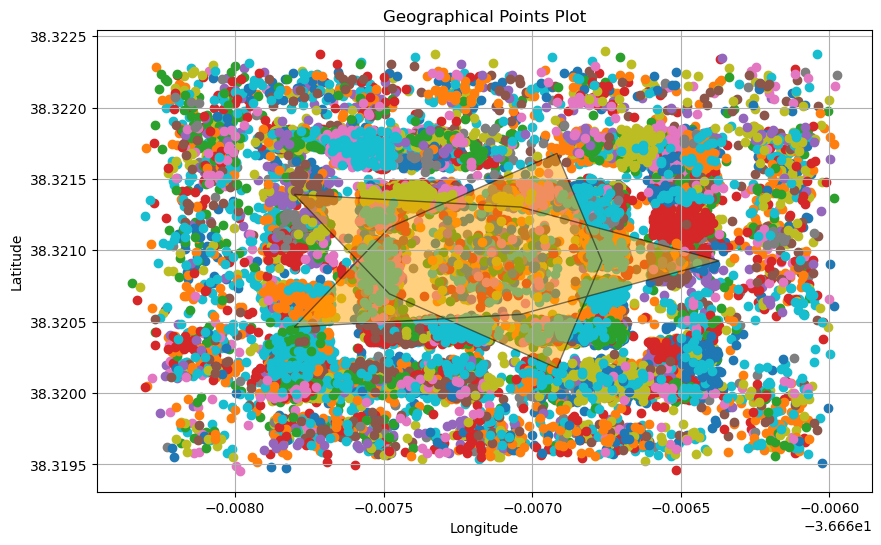

In [20]:
plt.figure(figsize=(10, 6))
for uid, group in df.groupby('uid'):
    plt.scatter(group['longitude'], group['latitude'], label=uid)

# Extracting the x and y coordinates from the star polygon for plotting
x, y = star_polygon.exterior.xy

# Plotting the star polygon
plt.fill(x, y, alpha=0.5, fc='orange', ec='black', label='Star Polygon')
    
plt.title('Geographical Points Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [23]:
polygon = star_polygon
min_x, min_y, max_x, max_y = polygon.bounds

In [30]:
filtered_df = filter_to_box(df, star_polygon, latitude='latitude', longitude='longitude')

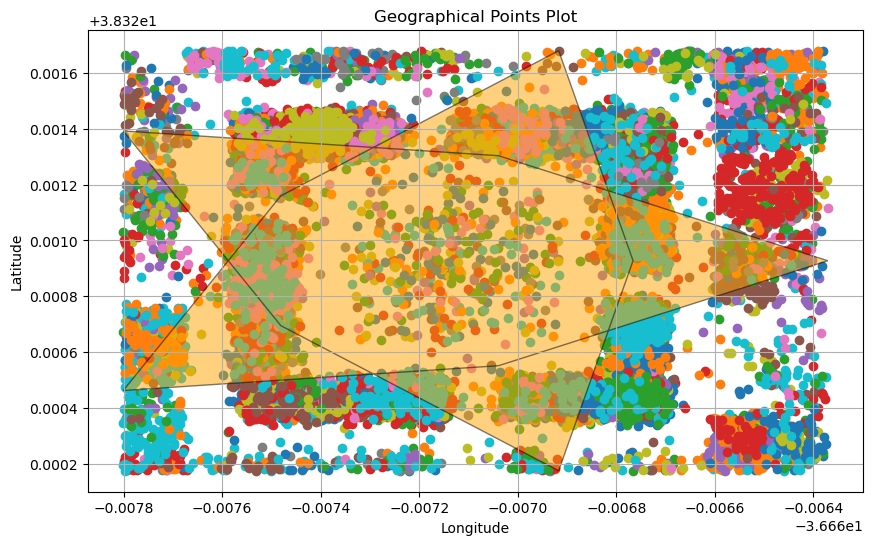

In [31]:
plt.figure(figsize=(10, 6))
for uid, group in filtered_df.groupby('uid'):
    plt.scatter(group['longitude'], group['latitude'], label=uid)

# Extracting the x and y coordinates from the star polygon for plotting
x, y = star_polygon.exterior.xy

# Plotting the star polygon
plt.fill(x, y, alpha=0.5, fc='orange', ec='black', label='Star Polygon')
    
plt.title('Geographical Points Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [27]:
# box filter: pass polygon, schema/var names, handle projections

def filter_to_box(df, polygon, latitude, longitude):
    '''
    Filters a DataFrame to keep only the points that lie within the bounds of a specified polygon.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing at least the specified `latitude` and `longitude` columns with
        the coordinates of the points to be filtered.

    polygon : shapely.geometry.Polygon
        A Shapely polygon object defining the area within which the points should be retained.

    latitude : str
        The name of the column containing the latitude coordinates in `df`.

    longitude : str
        The name of the column containing the longitude coordinates in `df`.

    Returns
    -------
    pd.DataFrame
        A filtered DataFrame containing only the points within the bounds of the specified polygon.
    '''
    min_x, min_y, max_x, max_y = polygon.bounds
    
    return df[(df[latitude].between(min_y, max_y)) & (df[longitude].between(min_x, max_x))]

In [37]:
def to_projection(df,
                   latitude,
                   longitude,
                   from_crs="EPSG:4326",
                   to_crs="EPSG:3857",
                   spark_session=None):
    
    proj_cols = _to_projection(df['latitude'],
                               df['longitude'],
                              from_crs,
                              to_crs)
    
    df['x'] = proj_cols.x
    df['y'] = proj_cols.y
    
    return df

def _to_projection(lat_col,
                   long_col,
                   from_crs,
                   to_crs):
    '''
    Parameters
    ----------
    lat_col, lon_col : Pandas Series
        The columns containing the latitude and longitude of the
        points in `df`.
    from_crs, to_crs : str, optional
        The codes of the original and target projections to use.
        If `to_crs` is None no reprojection is done.
        
    Returns
    -------
    df : pd.DataFrame or gpd.GeoDataFrame
        If `return_gdf` the df ported to a geodataframe in the `to_crs` projection.
        Otherwise, the original data frame with two additional columns named `lat_col + '_proj'`
        and `lon_col + '_proj'` containing the original coordinates projected to
        `to_crs`.
    '''
    gdf = gpd.GeoSeries( gpd.points_from_xy(long_col, lat_col),
                           crs=from_crs)
    projected = gdf.to_crs(to_crs)
    output = pd.DataFrame({'x': projected.x, 'y': projected.y})
    
    return output

In [38]:
to_projection(df, "latitude", "longitude")

,uid,timestamp,latitude,longitude,date,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01,-4.081792e+06,4.624968e+06
0,wonderful_swirles,1704121560,38.321017,-36.667869,2024-01-01,-4.081789e+06,4.624973e+06
0,youthful_galileo,1704098820,38.321625,-36.666612,2024-01-01,-4.081789e+06,4.624973e+06
1,youthful_galileo,1704103140,38.321681,-36.666841,2024-01-01,-4.081792e+06,4.624968e+06
...,...,...,...,...,...,...,...
1691,angry_spence,1705303380,38.320399,-36.667438,2024-01-15,-4.081731e+06,4.624742e+06
1692,angry_spence,1705303740,38.320413,-36.667469,2024-01-15,-4.081732e+06,4.624737e+06
1693,angry_spence,1705303980,38.320384,-36.667455,2024-01-15,-4.081733e+06,4.624730e+06
1694,angry_spence,1705304340,38.320349,-36.667473,2024-01-15,-4.081736e+06,4.624725e+06


In [ ]:
geopandas

In [ ]:
p_test = shapely.Point(*(sample_data.iloc[0][['x','y']]/(100*60*60)).astype(float).to_dict().values())

In [ ]:
zip_locs.contains(p_test)

## Subset data to sample of users

In [ ]:
# persist
#sample_data = pd.concat(output_data, ignore_index=True)
#pq.write_table(table, f's3://robustness-project/data_sample_40k.parquet', filesystem=s3)

# Incompleteness metrics

In [ ]:
sample_data

## Barcode plots for different users

In [ ]:
sample_data

In [ ]:
print(len(sample_data))
print(len(sample_data.drop_duplicates(['identifier', 'date_hour'])))

In [ ]:
# Plot barcodes
week1 = ('2019-10-08', '2019-10-15')
week2 = ('2019-10-15', '2019-10-22')
week3 = ('2019-10-22', '2019-10-29')
week4 = ('2019-10-29', '2019-11-05')

In [ ]:
#select a user with 20 hours in a whole month
hour_counts = sample_data.groupby(['identifier']).date_hour.count()

In [ ]:
user1 = hour_counts.loc[(hour_counts>100)&(hour_counts<600)].index[-1]
user2 = hour_counts.loc[(hour_counts>100)&(hour_counts<900)].index[0]
user3 = hour_counts.loc[(hour_counts>100)&(hour_counts<1000)].index[2]
hour_counts[[user1,user2,user3]]

In [ ]:
def plot_user_timeframe(sample_data, user, start, end, ax=None):
    # If no Axes is passed in, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 1))  # Aspect ratio 10:1

    df = sample_data.loc[(sample_data['identifier'] == user) & 
                         (sample_data['local_timestamp'] > start) & 
                         (sample_data['local_timestamp'] < end)].copy()
    df['day_of_week'] = df['local_timestamp'].dt.dayofweek + df['local_timestamp'].dt.hour / 24.0 + df['local_timestamp'].dt.minute / 1440.0
    #plotting
    ax.hlines(1, 0, 6, color='gray', linewidth=2)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='gray', linewidth=5, alpha=0.08)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='gray', linewidth=10, alpha=0.08)
    ax.vlines(df['day_of_week'], 0.95, 1.05, color='black', linewidth=0.5)
    # Set x-axis details
    ax.set_xlim(0, 6)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    #ax.xaxis.set_label_coords(0.5, -0.5)
    #y-axis
    ax.yaxis.set_visible(False)
    [spine.set_visible(False) for spine in ax.spines.values()]    
    # Title with number of records
    ax.set_title(f"User {user[-4:]}, N={len(df)}, week={start}", fontsize=10, pad=10)
    return ax

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user1, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user1, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user1, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
#plt.savefig('user1.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user2, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user2, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user2, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
#fig.savefig('./user2.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 3.6))  # for 2 plots, one above the other
plot_user_timeframe(sample_data, user3, week1[0], week1[1], ax=axs[0])
plot_user_timeframe(sample_data, user3, week2[0], week2[1], ax=axs[1])
plot_user_timeframe(sample_data, user3, week3[0], week3[1], ax=axs[2])

fig.subplots_adjust(hspace=2.0, wspace=0.4, top=1.8, bottom=1.0, left=0.1, right=0.9)
#fig.savefig('./user3.png')
plt.show()

## q score for each week

In [ ]:
start, end = week1

window = sample_data.loc[(sample_data['local_timestamp'] > start) & 
                         (sample_data['local_timestamp'] < end)].drop_duplicates(['identifier', 'date_hour'])
user_hours = window.groupby(['identifier']).date_hour.count()

In [ ]:
user_hours[(user_hours>=3)]

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(user_hours[(user_hours>=3)], bins=range(3, 56), edgecolor='black')  # 168 bins
plt.title(f'Active hours between {start} and {end}', fontsize=14)  # Incorporate start and end into the title
plt.xlabel('Hours', fontsize=15)  # Increase font size for x-axis label
plt.ylabel('Number of Users', fontsize=15)  # Increase font size for y-axis label
plt.grid(axis='y', alpha=0.75)

# Save the figure
#plt.savefig('./histogram.png')

# Show the plot
plt.show()

In [ ]:
normalized_hours = user_hours[(user_hours>=3)] / 168

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(normalized_hours, shade=True, color="blue", linewidth=1.5)

# Calculate and plot the median line within the specified range
median_value = normalized_hours.median()
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)



# Set title and labels with increased font size
plt.title(f'Active hours between {start} and {end}', fontsize=14)
plt.xlabel('q score', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Limit the range of x-axis to be between 0 and 0.4
plt.xlim(0, 0.5)

# Save the figure
#plt.savefig('normalized_hours_density.png')

# Show the plot
plt.show()